In [1]:
import pandas as pd
import requests
MODEL_NAME = "temp_model"

## Requisição de medições de temperatura

Site: 
https://open-meteo.com/

Exemplo retirado do site:
```shell
curl "https://archive-api.open-meteo.com/v1/era5?latitude=-26.49&longitude=-49.07&start_date=2022-01-01&end_date=2022-12-31&hourly=temperature_2m"
```

In [2]:
import requests
url = "https://archive-api.open-meteo.com/v1/era5"
# Jaraguá do sul - Latitude: -26.49, Longitude: -49.07
params = {
    "latitude": -26.49,
    "longitude": -49.07,       
    "start_date": "2022-01-01",
    "end_date": "2022-12-31",
    "hourly": "temperature_2m"
}

response = requests.get(url, params=params)

if response.status_code == 200:
    data = response.json()
    print("Requisição Ok", data.keys())
    df = pd.DataFrame(data["hourly"])
else:
    print("Error:", response.status_code, response.text)

Requisição Ok dict_keys(['latitude', 'longitude', 'generationtime_ms', 'utc_offset_seconds', 'timezone', 'timezone_abbreviation', 'elevation', 'hourly_units', 'hourly'])


In [3]:
# Modifica nome da coluna
df = df.rename({"temperature_2m": "temperatura"}, axis='columns')
# Visualização inicial
df.describe()

,temperatura
count,8760.000000
mean,20.072283
std,4.491420
min,6.000000
25%,16.700000
50%,20.000000
75%,23.200000
max,33.200000


In [4]:
df.head()

,time,temperatura
0,2022-01-01T00:00,21.7
1,2022-01-01T01:00,21.4
2,2022-01-01T02:00,21.0
3,2022-01-01T03:00,20.7
4,2022-01-01T04:00,20.4


Os seguintes valores serão usados, apenas como exemplo, para classificar as temperaturas deste dataset:
- Frio: menor que 20°C;
- Agradável: entre 20°C e 25°C;
- Quente: acima de 25°C.

In [5]:
from enum import Enum

class ClassesTemperatura(Enum):
    Frio = 0
    Agradavel = 1
    Quente = 2

# Classifica as temperaturas com base na classe acima
def classifica_temperatura(temp):
    if temp < 20:
        return ClassesTemperatura.Frio.value
    elif temp >= 20 and temp <= 25:
        return ClassesTemperatura.Agradavel.value
    else:
        return ClassesTemperatura.Quente.value

# Cria a nova coluna com as classificações
df["classe"] = df["temperatura"].apply(classifica_temperatura)

df.describe()

,temperatura,classe
count,8760.000000,8760.000000
mean,20.072283,0.642123
std,4.491420,0.712540
min,6.000000,0.000000
25%,16.700000,0.000000
50%,20.000000,1.000000
75%,23.200000,1.000000
max,33.200000,2.000000


In [6]:
df.head()

,time,temperatura,classe
0,2022-01-01T00:00,21.7,1
1,2022-01-01T01:00,21.4,1
2,2022-01-01T02:00,21.0,1
3,2022-01-01T03:00,20.7,1
4,2022-01-01T04:00,20.4,1


In [7]:
print("Quantidade de amostras em 'frio'", df[df["classe"] == 0].count())
print("Quantidade de amostras em 'agradável'", df[df["classe"] == 1].count())
print("Quantidade de amostras em 'quente'", df[df["classe"] == 2].count())

Quantidade de amostras em 'frio' time           4352
temperatura    4352
classe         4352
dtype: int64
Quantidade de amostras em 'agradável' time           3191
temperatura    3191
classe         3191
dtype: int64
Quantidade de amostras em 'quente' time           1217
temperatura    1217
classe         1217
dtype: int64


In [8]:
df.tail()

,time,temperatura,classe
8755,2022-12-31T19:00,28.0,2
8756,2022-12-31T20:00,26.6,2
8757,2022-12-31T21:00,25.6,2
8758,2022-12-31T22:00,24.5,1
8759,2022-12-31T23:00,23.5,1


## Treinamento

In [10]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Dividir os dados em X e rótulos (y)
X = df['temperatura'].values.reshape(-1, 1)
y = df['classe'].values

# Normaliza X
scaler = StandardScaler()
X = scaler.fit_transform(X)



In [22]:
# Acessa o vetor médio usado para normalizar os dados
mean = scaler.mean_

# Acessa o vetor de desvio padrão usado para normalizar os dados
std = scaler.scale_

# Imprime os vetores médio e de desvio padrão
print(mean)
print(std)


[20.07228311]
[4.49116319]


In [11]:
# Dividir os dados em conjuntos de treinamento e teste
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [12]:
# Importar as bibliotecas necessárias
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Input

from tensorflow.keras.utils import to_categorical


# Criar o modelo
model = Sequential()

model.add(Input(shape=(1,)))
model.add(Dense(5, activation='relu'))
model.add(Dense(3, activation='sigmoid'))

# Compilar o modelo
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

print(X_train.shape, y_train.shape)

# Treina o modelo
history = model.fit(X_train, to_categorical(y_train), epochs=10, verbose=1)




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 10        
                                                                 
 dense_1 (Dense)             (None, 3)                 18        
                                                                 
Total params: 28
Trainable params: 28
Non-trainable params: 0
_________________________________________________________________
None
(6570, 1) (6570,)
Epoch 1/10
206/206 [==============================] - 2s 3ms/step - loss: 1.0518 - accuracy: 0.5604
Epoch 2/10
206/206 [==============================] - 0s 2ms/step - loss: 0.7397 - accuracy: 0.7967
Epoch 3/10
206/206 [==============================] - 1s 3ms/step - loss: 0.5639 - accuracy: 0.9125
Epoch 4/10
206/206 [==============================] - 1s 3ms/step - loss: 0.4453 - accuracy: 0.9376
Epoch 5/10
206/206 [=============

In [13]:
# Avaliar o modelo nas amostras de teste
loss, accuracy = model.evaluate(X_test, to_categorical(y_test), verbose=1)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

69/69 [==============================] - 1s 4ms/step - loss: 0.1434 - accuracy: 0.9918
Test Loss: 0.143411785364151
Test Accuracy: 0.9917808175086975


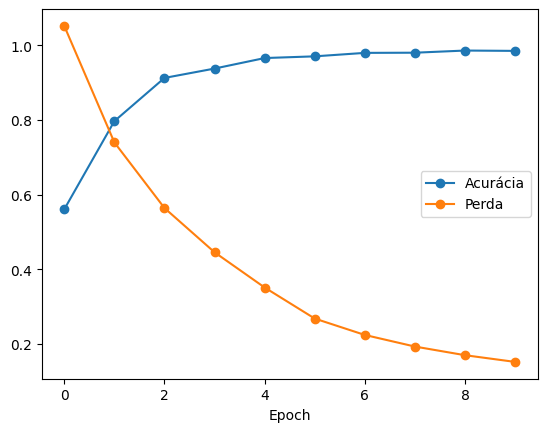

In [14]:
import matplotlib.pyplot as plt
# Plotar a acurácia e a perda em um único gráfico
plt.plot(history.history['accuracy'], marker='o')
plt.plot(history.history['loss'], marker='o')
plt.xlabel('Epoch')
plt.legend(['Acurácia', 'Perda'], loc='center right')






plt.show()

In [15]:
print(y_train)

[2 0 0 ... 2 0 0]


In [16]:
# Define algumas temperaturas para testar
temperaturas_teste = [-1, 10, 20, 25, 30, 40]

# Normaliza as temperaturas usando o scaler treinado
temperaturas_teste_norm = scaler.transform(np.array(temperaturas_teste).reshape(-1, 1))
print(temperaturas_teste_norm)
# Usa o modelo para fazer a previsão das classes para as temperaturas de teste
y_pred = model.predict(temperaturas_teste_norm)

# Obtém a classe com maior probabilidade para cada temperatura de teste

y_categorias_pred = np.argmax(y_pred, axis=1)

print(y_categorias_pred)

[[-4.69194331]
 [-2.24268918]
 [-0.01609452]
 [ 1.09720281]
 [ 2.21050015]
 [ 4.43709481]]
1/1 [==============================] - 0s 141ms/step
[0 0 1 1 2 2]


In [30]:

model.save(f'{MODEL_NAME}.h5')

In [29]:
from tensorflow.keras.models import load_model
import tensorflow as tf
model = load_model(f'{MODEL_NAME}.h5')
# Define o conversor
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Define as opções de conversão para incluir as informações de escala e zero_point
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.inference_input_type = tf.float32
converter.inference_output_type = tf.float32

# Adiciona o objeto de metadados ao modelo convertido
tflite_model = converter.convert()

with open(f'{MODEL_NAME}.tflite', 'wb') as f:
    f.write(tflite_model)

xxd -i converted_model.tflite > ./main/model.cc

## Testes da precisão do modelo gerado lite

In [20]:
!pip install tflite_runtime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement tflite_runtime (from versions: none)
ERROR: No matching distribution found for tflite_runtime


In [21]:
tflite_interpreter = tf.lite.Interpreter(
    model_path=f'{MODEL_NAME}.tflite',
    experimental_op_resolver_type=tf.lite.experimental.OpResolverType.
    BUILTIN_REF,
)
tflite_interpreter.allocate_tensors()

input_details = tflite_interpreter.get_input_details()[0]
output_details = tflite_interpreter.get_output_details()[0]

print("== Input details ==")
print("name:", input_details['name'])
print("shape:", input_details['shape'])
print("type:", input_details['dtype'])

print("\n== Output details ==")
print("name:", output_details['name'])
print("shape:", output_details['shape'])
print("type:", output_details['dtype'])


# Obtém as escalas e offsets dos dados de entrada e saída
input_scale, input_zero_point = input_details['quantization']
output_scale, output_zero_point = output_details['quantization']

print('Input scale:', input_scale)
print('Input zero point:', input_zero_point)
print('Output scale:', output_scale)
print('Output zero point:', output_zero_point)

== Input details ==
name: serving_default_input_1:0
shape: [1 1]
type: <class 'numpy.float32'>

== Output details ==
name: StatefulPartitionedCall:0
shape: [1 3]
type: <class 'numpy.float32'>
Input scale: 0.0
Input zero point: 0
Output scale: 0.0
Output zero point: 0


In [25]:
import time
input_shape = input_details['shape']
temperature = 10 
correct_predictions = 0
total_predictions = 0
total_time = 0
while (temperature <= 30):
    start_time = time.time()
    value = (temperature - mean) / std
    input_data = np.reshape(value, input_shape).astype(np.float32)

    tflite_interpreter.set_tensor(input_details['index'], input_data)
    tflite_interpreter.invoke()
    total_time += time.time() - start_time

    tflite_output = tflite_interpreter.get_tensor(output_details['index'])
    
    y_quantized = np.argmax(tflite_output, axis=1)
    total_predictions += 1

    # Compare with ground truth labels and update accuracy
    if y_quantized == classifica_temperatura(temperature):
        correct_predictions += 1

    print(f"{temperature} -> {input_data}:", y_quantized)
    temperature += 0.5

accuracy = correct_predictions / total_predictions
avg_time = total_time / total_predictions
print(f"Accuracy: {accuracy*100}")
print(f"Tempo médio de execução: {avg_time:.5f} segundos")

10 -> [[-2.2426891]]: [0]
10.5 -> [[-2.1313593]]: [0]
11.0 -> [[-2.0200298]]: [0]
11.5 -> [[-1.9087]]: [0]
12.0 -> [[-1.7973702]]: [0]
12.5 -> [[-1.6860405]]: [0]
13.0 -> [[-1.5747107]]: [0]
13.5 -> [[-1.463381]]: [0]
14.0 -> [[-1.3520513]]: [0]
14.5 -> [[-1.2407216]]: [0]
15.0 -> [[-1.1293919]]: [0]
15.5 -> [[-1.0180621]]: [0]
16.0 -> [[-0.9067324]]: [0]
16.5 -> [[-0.79540265]]: [0]
17.0 -> [[-0.6840729]]: [0]
17.5 -> [[-0.5727432]]: [0]
18.0 -> [[-0.46141344]]: [0]
18.5 -> [[-0.3500837]]: [0]
19.0 -> [[-0.23875399]]: [0]
19.5 -> [[-0.12742426]]: [0]
20.0 -> [[-0.01609452]]: [1]
20.5 -> [[0.09523521]]: [1]
21.0 -> [[0.20656495]]: [1]
21.5 -> [[0.31789467]]: [1]
22.0 -> [[0.4292244]]: [1]
22.5 -> [[0.54055417]]: [1]
23.0 -> [[0.6518839]]: [1]
23.5 -> [[0.76321363]]: [1]
24.0 -> [[0.87454337]]: [1]
24.5 -> [[0.9858731]]: [1]
25.0 -> [[1.0972028]]: [1]
25.5 -> [[1.2085326]]: [2]
26.0 -> [[1.3198622]]: [2]
26.5 -> [[1.431192]]: [2]
27.0 -> [[1.5425217]]: [2]
27.5 -> [[1.6538515]]: [2]
28.

In [24]:
# imprime o número de neurônios em cada camada
for layer in model.layers:
    print(layer.output_shape[1])

5
3


Testes com geração de modelo quantizado

In [38]:
# ref: https://github.com/tensorflow/tflite-micro/blob/main/tensorflow/lite/micro/examples/hello_world/quantization/ptq.py
def convert_quantized_tflite_model(source_model_dir, x_values):
  """Convert the save TF model to tflite model, then save it as .tflite
    flatbuffer format
    Args:
        source_model_dir (tf.keras.Model): the trained hello_world flaot Model dir
        x_train (numpy.array): list of the training data
    Returns:
        The converted model in serialized format.
  """

  # Convert the model to the TensorFlow Lite format with quantization
  def representative_dataset(num_samples=500):
    for i in range(num_samples):
      yield [x_values[i].reshape(1, 1)]
  model = load_model(f'{MODEL_NAME}.h5')
  converter = tf.lite.TFLiteConverter.from_keras_model(model)
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
  converter.inference_input_type = tf.int8
  converter.inference_output_type = tf.int8
  converter.representative_dataset = representative_dataset
  tflite_model = converter.convert()
  return tflite_model


In [41]:
quantized_tflite_model = convert_quantized_tflite_model(
      './temp_model.h5', 
      X.astype(np.float32)
)
with open(f'{MODEL_NAME}_quantized.tflite', 'wb') as f:
    f.write(quantized_tflite_model)

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:789: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
